In [1]:
!pip install gensim
!pip install jieba
!pip install underthesea

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import jieba
import re

In [3]:
#Have to include to remove stop word
STOP_WORD_FILE = '/content/drive/MyDrive/Recommandation_System_dataset/vietnamese-stopwords.txt'

In [4]:
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

In [5]:
stop_words

['a_lô',
 'a_ha',
 'ai',
 'ai_ai',
 'ai_nấy',
 'ai_đó',
 'alô',
 'amen',
 'anh',
 'anh_ấy',
 'ba',
 'ba_ba',
 'ba_bản',
 'ba_cùng',
 'ba_họ',
 'ba_ngày',
 'ba_ngôi',
 'ba_tăng',
 'bao_giờ',
 'bao_lâu',
 'bao_nhiêu',
 'bao_nả',
 'bay_biến',
 'biết',
 'biết_bao',
 'biết_bao_nhiêu',
 'biết_chắc',
 'biết_chừng_nào',
 'biết_mình',
 'biết_mấy',
 'biết_thế',
 'biết_trước',
 'biết_việc',
 'biết_đâu',
 'biết_đâu_chừng',
 'biết_đâu_đấy',
 'biết_được',
 'buổi',
 'buổi_làm',
 'buổi_mới',
 'buổi_ngày',
 'buổi_sớm',
 'bà',
 'bà_ấy',
 'bài',
 'bài_bác',
 'bài_bỏ',
 'bài_cái',
 'bác',
 'bán',
 'bán_cấp',
 'bán_dạ',
 'bán_thế',
 'bây_bẩy',
 'bây_chừ',
 'bây_giờ',
 'bây_nhiêu',
 'bèn',
 'béng',
 'bên',
 'bên_bị',
 'bên_có',
 'bên_cạnh',
 'bông',
 'bước',
 'bước_khỏi',
 'bước_tới',
 'bước_đi',
 'bạn',
 'bản',
 'bản_bộ',
 'bản_riêng',
 'bản_thân',
 'bản_ý',
 'bất_chợt',
 'bất_cứ',
 'bất_giác',
 'bất_kì',
 'bất_kể',
 'bất_kỳ',
 'bất_luận',
 'bất_ngờ',
 'bất_nhược',
 'bất_quá',
 'bất_quá_chỉ',
 'bất_thình_l

In [6]:
data_content = pd.read_csv('/content/drive/MyDrive/Recommandation_System_dataset/Products_ThoiTrangNam_raw.csv')

In [7]:
data_content

,product_id,product_name,category,sub_category,link,image,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
...,...,...,...,...,...,...,...,...,...
49658,175063,"Tất vớ nam cổ cao cao cấp, tất vớ đi giày công...",Thời Trang Nam,Vớ/Tất,https://shopee.vn/T%E1%BA%A5t-v%E1%BB%9B-nam-c...,https://cf.shopee.vn/file/b58abf3233ec6b1d7c6a...,15000.0,4.0,Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nChiề...
49659,175064,Tất Nam Livan Sport Chất Liệu Bamboo Kháng Khu...,Thời Trang Nam,Vớ/Tất,https://shopee.vn/T%E1%BA%A5t-Nam-Livan-Sport-...,https://cf.shopee.vn/file/fbfe473750ebea09e138...,68000.0,4.5,Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nThươ...
49660,175065,Combo 3 Đôi Tất ( Vớ ) Hài Chống Hôi Chân Uni ...,Thời Trang Nam,Vớ/Tất,https://shopee.vn/Combo-3-%C4%90%C3%B4i-T%E1%B...,https://cf.shopee.vn/file/744ffeaefe2df8a15046...,39700.0,4.6,Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nChất...
49661,175066,Hộp 10 đôi tất chống hôi chân nam,Thời Trang Nam,Vớ/Tất,https://shopee.vn/H%E1%BB%99p-10-%C4%91%C3%B4i...,https://cf.shopee.vn/file/a1ad2e57e22f757b2898...,79000.0,4.5,Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nKho ...


In [11]:
amount= 20000
if amount > 0:
    data_content= data_content.iloc[:amount, :]
data_content.tail()

,product_id,product_name,category,sub_category,link,image,price,rating,description
9995,102576,Cà Vạt Lụa Dệt 8cm Phong Cách Cổ Điển Cho Nam,Thời Trang Nam,Cà vạt & Nơ cổ,https://shopee.vn/C%C3%A0-V%E1%BA%A1t-L%E1%BB%...,https://cf.shopee.vn/file/340e4c40848e2acc171a...,74592.0,0.0,Danh Mục\nShopee\nThời Trang Nam\nCà vạt & Nơ ...
9996,102577,Bộ Cà Vạt Hàn Quốc 4 trong 1 - Mã HVC017,Thời Trang Nam,Cà vạt & Nơ cổ,https://shopee.vn/B%E1%BB%99-C%C3%A0-V%E1%BA%A...,https://cf.shopee.vn/file/23a612e31cedd0e6d813...,251100.0,0.0,Danh Mục\nShopee\nThời Trang Nam\nCà vạt & Nơ ...
9997,102578,Bộ Cà Vạt Hàn Quốc 4 trong 1 - Mã HVC016,Thời Trang Nam,Cà vạt & Nơ cổ,https://shopee.vn/B%E1%BB%99-C%C3%A0-V%E1%BA%A...,https://cf.shopee.vn/file/9a88f804ae9ca3befc5f...,251100.0,0.0,Danh Mục\nShopee\nThời Trang Nam\nCà vạt & Nơ ...
9998,102579,Cà Vạt Nam Đính Đá Handmade,Thời Trang Nam,Cà vạt & Nơ cổ,https://shopee.vn/C%C3%A0-V%E1%BA%A1t-Nam-%C4%...,https://cf.shopee.vn/file/4b6bd01a0cf945dcba3b...,60500.0,0.0,Danh Mục\nShopee\nThời Trang Nam\nCà vạt & Nơ ...
9999,102580,Cà Vạt Đồng Phục JK / DK Thiết Kế Độc Đáo Thời...,Thời Trang Nam,Cà vạt & Nơ cổ,https://shopee.vn/C%C3%A0-V%E1%BA%A1t-%C4%90%E...,https://cf.shopee.vn/file/d02fd740be354d2646f6...,188000.0,0.0,Danh Mục\nShopee\nThời Trang Nam\nCà vạt & Nơ ...


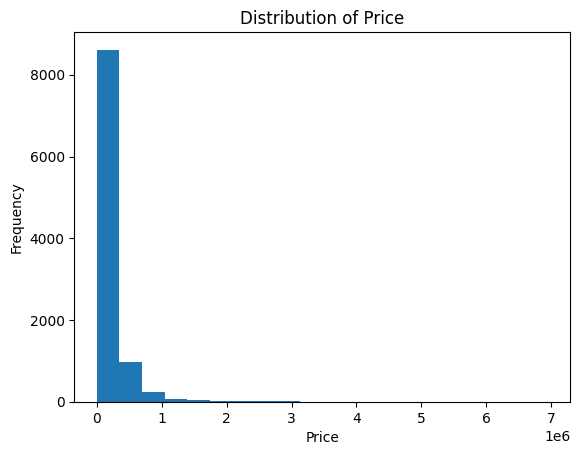

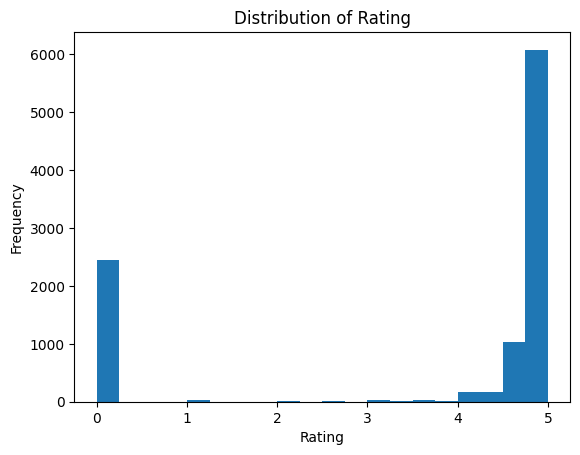

In [12]:
import matplotlib.pyplot as plt

# histogram for 'price'
plt.hist(data_content['price'], bins=20)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# histogram for 'rating'
plt.hist(data_content['rating'], bins=20)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

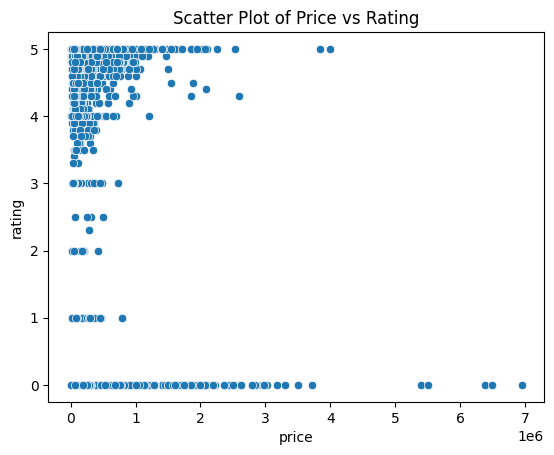

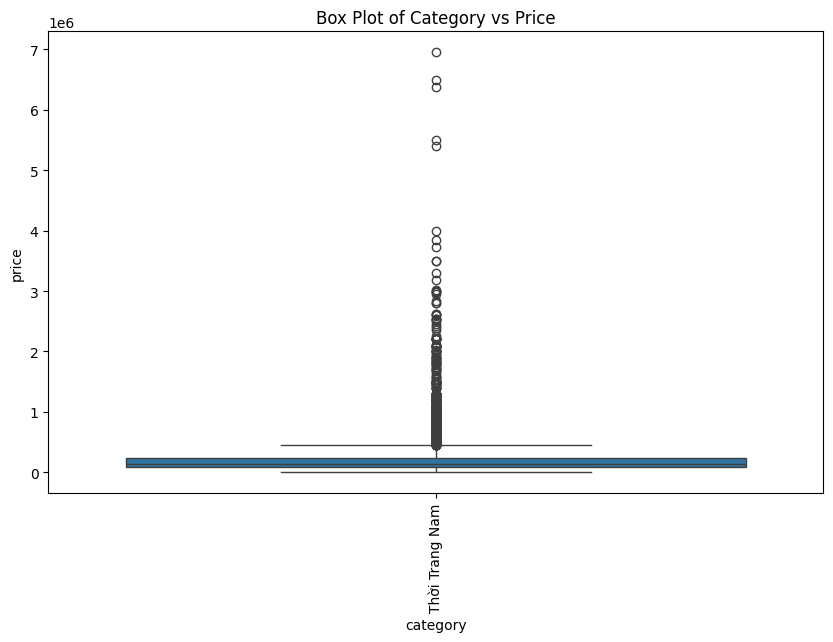

In [13]:
import seaborn as sns

# scatter plot 'price' and 'rating'
sns.scatterplot(x='price', y='rating', data=data_content)
plt.title('Scatter Plot of Price vs Rating')
plt.show()

# Boxplot 'category' and 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='price', data=data_content)
plt.title('Box Plot of Category vs Price')
plt.xticks(rotation=90)
plt.show()

In [14]:
# word_tokenize, turn sentence into a sequence of word
nameCol= data_content.columns[1]
nameWtCol= nameCol + '_wt'
data_content[nameWtCol]= data_content[nameCol].apply(lambda s: word_tokenize(s, format= 'text'))
# Tokenize(split) the sentences into words
products_gem = [[text for text in x.split()] for x in data_content[nameWtCol]]
# remove some special elements in texts
products_gem_re = [[re.sub('[0-9]+','', e) for e in text] for text in products_gem] # xóa số
products_gem_re = [[t.lower() for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '_%' , '(', ')', '+', '/', 'g', 'ml']] for text in  products_gem_re] # xóa ký tự đặc biệt
products_gem_re = [[t for t in text if not t in stop_words] for text in products_gem_re] # xóa các stopword


In [15]:
# Obtain the number of features based on dictionary: Use corpora.Dictionary
dictionary = corpora.Dictionary(products_gem_re)

In [16]:
# List of features in dictionary
dictionary.token2id

{'body': 0,
 'form': 1,
 'gân': 2,
 'lỗ': 3,
 'thun': 4,
 'tôn_dáng': 5,
 'áo': 6,
 'ba_lỗ': 7,
 'chất_cotton': 8,
 'nam_trắng': 9,
 'siêu_mát': 10,
 'siêu_đẹp': 11,
 'chất': 12,
 'co_dãn': 13,
 'không': 14,
 'mát': 15,
 'mềm': 16,
 'mịn': 17,
 'nam_tyasuo': 18,
 'vải': 19,
 'xù': 20,
 'cotton': 21,
 'hàng_việt_nam': 22,
 'bl': 23,
 'mẫu_mới': 24,
 'thun_nam': 25,
 'thể_thao': 26,
 'cao_cấp': 27,
 'chất_liệu': 28,
 'co_giãn': 29,
 'hàng': 30,
 'hút': 31,
 'may_kĩ': 32,
 'mồ_hôi': 33,
 'nam': 34,
 'sát_nách': 35,
 'thấm': 36,
 'đường': 37,
 'gym': 38,
 'kiểu': 39,
 'lót_form': 40,
 'màu': 41,
 'mịn_tập': 42,
 'rộng': 43,
 'tank_top': 44,
 'unifun_áo': 45,
 'hàng_đẹp': 46,
 'nam_shark': 47,
 'thun_tập': 48,
 'thể_nam': 49,
 '[': 50,
 ']': 51,
 ']_áo': 52,
 'al': 53,
 'coton': 54,
 'may': 55,
 'mã_skamonth': 56,
 'mặc': 57,
 'mặc_lót': 58,
 'mỏng_mát': 59,
 'nhà_[': 60,
 'ô_vải': 61,
 'đơn_k': 62,
 'cộc_tay': 63,
 'lót_nam': 64,
 'màu_trắng': 65,
 'nhật_maxtino': 66,
 'đông_xuân_xuất': 67

In [17]:
# Numbers of features (word) in dictionary
feature_cnt = len(dictionary.token2id)
feature_cnt

11766

In [18]:
# Number appear of word
corpus = [dictionary.doc2bow(text) for text in products_gem_re]

In [19]:
# Use TF-IDF Model to process corpus, obtaining index
tfidf = models.TfidfModel(corpus)
# tính toán sự tương tự trong ma trận thưa thớt
index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)


In [20]:
data_result = pd.DataFrame(index[tfidf[corpus]])


In [21]:
iSelect= 208
n= 5
highSel= data_result.iloc[iSelect]
print(highSel)
highSel= highSel.argsort()[::-1][:n]
highSel

0       0.004253
1       0.121592
2       0.100225
3       0.164458
4       0.128872
          ...   
9995    0.000000
9996    0.000000
9997    0.000000
9998    0.000000
9999    0.000000
Name: 208, Length: 10000, dtype: float32


,208
9999,208
9998,1136
9997,767
9996,1056
9995,1186


In [22]:

data_content.iloc[highSel]

,product_id,product_name,category,sub_category,link,image,price,rating,description,product_name_wt
208,191008,Áo Ba Lỗ Croptop Nữ,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Cropto...,https://cf.shopee.vn/file/169ec41d8e32ec6b3ec6...,39500.0,0.0,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...,Áo Ba_Lỗ Croptop_Nữ
1136,19636,Áo Ba lỗ cho Nam,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-l%E1%BB%97-cho-Na...,NaN,100000.0,4.0,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,Áo Ba_lỗ cho Nam
767,19267,Áo Ba Lỗ Thể Thao Cho Nam,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Th%E1%...,NaN,91800.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,Áo Ba_Lỗ Thể_Thao Cho_Nam
1056,19556,Áo Thun Ba Lỗ Thời Trang Dành Cho Nam,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Ba-L%E1%BB%97-T...,https://cf.shopee.vn/file/43bf64e153028490d2bf...,230000.0,5.0,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,Áo Thun Ba_Lỗ Thời_Trang Dành Cho_Nam
1186,19686,Áo Thun Ba Lỗ Thời Trang Dành Cho Nam,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Ba-L%E1%BB%97-T...,NaN,81950.0,5.0,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,Áo Thun Ba_Lỗ Thời_Trang Dành Cho_Nam


In [23]:
s_lst = ['áo thun ba lổ', 'áo thun việt nam']  # Example for output
# pre-process in s_lst
ws= [word_tokenize(s, format= 'text') for s in s_lst]
# Tokenize(split) the sentences into words
ws_gem = [[text for text in x.split()] for x in ws]
# remove some special elements in texts
ws_gem_re = [[re.sub('[0-9]+', '', e).lower() for e in text] for text in ws_gem] # xóa số, chuyển thành chuỗi chữ thường
ws_gem_re = [[t for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '_%' , '(', ')', '+', '/', 'g', 'ml']] for text in  ws_gem_re] # xóa ký tự đặc biệt
ws_gem_re = [[t for t in text if not t in stop_words] for text in ws_gem_re] # xóa các stopword

import os
# create vector TF-IDF in s_lst
vectorizer = TfidfVectorizer(vocabulary=dictionary.token2id)
s_lst_tfidf = vectorizer.fit_transform([' '.join(tokens) for tokens in ws_gem_re])


s_lst_corpus_tfidf = [vectorizer.transform([' '.join(tokens)]) for tokens in ws_gem_re]
s_lst_similarities = []

for s_tfidf in s_lst_corpus_tfidf:
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)
    similarity = index[s_tfidf]
    s_lst_similarities.append(similarity)

n = 5
result = []
for sim_scores in s_lst_similarities:
    top_indices = np.argsort(sim_scores)[::-1][:n]
    # top_ids = [products_df.iloc[i]['product_id'] for i in top_indices]
    result.append(top_indices)

# Show the result
for i, sentence_ids in enumerate(result):
    print('-'*50)
    print(f"Câu [{i}]'{s_lst[i]}' --> có các id tương tự: {sentence_ids}")
    for j in sentence_ids:
        lst= data_content.iloc[j][nameCol]
        print(f'id:[{j}]--> {lst}\n')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


--------------------------------------------------
Câu [0]'áo thun ba lổ' --> có các id tương tự: [ 440 2021  543  473 1290]
id:[440]--> Combo 3 áo thun ba lổ thể thao áo body bao đẹp

id:[2021]--> Áo tay dài

id:[543]--> Áo ba lổ Nam Insidemen

id:[473]--> Combo 2 áo thun cổ + 2 áo ba lổ nam!!

id:[1290]--> Áo ba lỗ gym VanQuish ,Áo thể thao ba lổ tập gym nam

--------------------------------------------------
Câu [1]'áo thun việt nam' --> có các id tương tự: [5391 4720 2021 5482  281]
id:[5391]--> ÁO VIỆT NAM XANH

id:[4720]--> ÁO THANH NIÊN VIỆT NAM CAO CẤP

id:[2021]--> Áo tay dài

id:[5482]--> Combo áo và bộ hàng Việt Nam xuất khẩu

id:[281]--> ÁO SÁT NÁCH VIỆT NAM XUẤT KHẨU



***Cosine_similarity***

In [24]:
tf = TfidfVectorizer(analyzer='word', stop_words=stop_words)

In [25]:
tfidf_matrix = tf.fit_transform(data_content[nameWtCol])

In [26]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [27]:
cosine_similarities.shape

(10000, 10000)

In [28]:
# To each product recommand 5
nCount= 5
results = {}

for idx, row in data_content.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[-1 - nCount:-1]
    # similar_items = [(cosine_similarities[idx][i]) for i in similar_indices]
    similar_items = [(cosine_similarities[idx][i], data_content.index[i]) for i in similar_indices]
    results[idx] = similar_items[0:]

In [29]:
iSelect= 800
results[iSelect]

[(0.4211313551261373, 42),
 (0.4390409331947444, 258),
 (0.6538549965081855, 931),
 (0.677928645517909, 851),
 (0.7850095032606389, 398)]

In [30]:
data_content[nameCol].head()

,product_name
0,"Áo ba lỗ thun gân ,form body tôn dáng"
1,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp"
2,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không..."
3,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON
4,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...


In [32]:
s_lst = ['áo thun ba lổ', 'áo thun việt nam']  # Ví dụ danh sách các câu cần đề xuất
# pre-process các câu trong s_lst
ws= [word_tokenize(s, format= 'text') for s in s_lst]
# Tokenize(split) the sentences into words
ws_gem = [[text for text in x.split()] for x in ws]
# remove some special elements in texts
ws_gem_re = [[re.sub('[0-9]+', '', e).lower() for e in text] for text in ws_gem] # xóa số, chuyển thành chuỗi chữ thường
ws_gem_re = [[t for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '_%' , '(', ')', '+', '/', 'g', 'ml']] for text in  ws_gem_re] # xóa ký tự đặc biệt
ws_gem_re = [[t for t in text if not t in stop_words] for text in ws_gem_re] # xóa các stopword
ws_texts = [' '.join(tokens) for tokens in ws_gem_re]

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Using TfidfVectorizer create TF-IDF for text
# tf = TfidfVectorizer(analyzer='word', stop_words=stop_words)
# tfidf_matrix = tf.fit_transform(ws_texts)
tf_ws_texts = tf.transform(ws_texts)
# cosine_similarities = cosine_similarity(tf, tfidf_matrix)

# calculate cosine similarity matrix
cosine_similarities = cosine_similarity(tf_ws_texts, tfidf_matrix)
print(cosine_similarities)

n = 5  # Only 5 ID recommand in s_lst
result = []
for i, row in enumerate(cosine_similarities):
    similar_indices = row.argsort()[-n-1:-1][::-1]  # Lấy n câu tương tự, bỏ qua câu gốc
    # similar_indices = row.argsort()[:n]#[::-1][:n]
    result.append(similar_indices)

# Show result
for i, sentence_ids in enumerate(result):
    print('-'*50)
    print(f"[{i}]'{s_lst[i]}' --> the one have same number ID: {sentence_ids}")
    for j in sentence_ids:
        lst= data_content.iloc[j][nameCol]
        print(f'id:[{j}]--> {lst}\n')

[[0.11596951 0.02230838 0.01837174 ... 0.         0.         0.        ]
 [0.13626466 0.02621244 0.02158687 ... 0.         0.         0.        ]]
--------------------------------------------------
[0]'áo thun ba lổ' --> the one have same number ID: [ 440  543 1290  449 1131]
id:[440]--> Combo 3 áo thun ba lổ thể thao áo body bao đẹp

id:[543]--> Áo ba lổ Nam Insidemen

id:[1290]--> Áo ba lỗ gym VanQuish ,Áo thể thao ba lổ tập gym nam

id:[449]--> Áo.ba lổ gymshark Luxe V20

id:[1131]--> áo ba lổ Fruit Of the loom

--------------------------------------------------
[1]'áo thun việt nam' --> the one have same number ID: [4720  281 5482  544 9715]
id:[4720]--> ÁO THANH NIÊN VIỆT NAM CAO CẤP

id:[281]--> ÁO SÁT NÁCH VIỆT NAM XUẤT KHẨU

id:[5482]--> Combo áo và bộ hàng Việt Nam xuất khẩu

id:[544]--> Áo tanktop Kwin Việt Nam

id:[9715]--> Cà Vạt Đoàn Thanh Niên Việt Nam Cao Cấp

